In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, pandas_udf
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from time import perf_counter

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
file_sizes = ["50k", "100k", "200k", "500k"]
file_paths = [f"hdfs://192.168.2.47:9000/data-project/reddit_{size}.json" for size in file_sizes]

# Number of Executors
nodes = [1, 2, 3]

#Store calculation results
results = []
for node in nodes:
    if "spark_session" in locals():
        spark_session.stop()
    # Create a SparkSession and set the number of Executors
    # conf = SparkConf().setAppName("Reddit Scalability Test").set("spark.executor.instances", str(node))
    # spark = SparkSession.builder.config(conf=conf).getOrCreate()
    spark_session = SparkSession.builder \
    .master("spark://192.168.2.47:7077") \
    .appName("test") \
    .config("spark.dynamicAllocation.enabled", True) \
    .config("spark.dynamicAllocation.shuffleTracking.enabled", True) \
    .config("spark.shuffle.service.enabled", False) \
    .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
    .config("spark.executor.instances", int(node)) \
    .config("spark.executor.cores", 12) \
    .config("spark.cores.max", 12) \
    .config("spark.executor.memory", "5G") \
    .getOrCreate()

    sc = spark_session.sparkContext  # get SparkContext
    print(f"Set executor instances to: {spark_session.conf.get('spark.executor.instances')}")
    # print(f" Running with {node} Executors")

    #############################################################################################################################

    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    sia = SentimentIntensityAnalyzer()
    
    @pandas_udf("string")
    def preprocess_text_udf(text_series: pd.Series) -> pd.Series:
        def preprocess(text):
            # Lowercase the text
            text = text.lower()
            
            # Remove special characters and extra spaces
            text = re.sub(r'\W+', ' ', text)
            
            # Split text into words
            words = text.split()
        
            # Remove stopwords
            words = [w for w in words if w not in stop_words]
        
            # Lemmatize words
            words = [lemmatizer.lemmatize(w) for w in words]
        
            out_text = ' '.join(words)
        
            return out_text
    
        return text_series.apply(preprocess)
    
    @pandas_udf("float")
    def sentiment_score_udf(text_series: pd.Series) -> pd.Series:
        return text_series.apply(lambda text: sia.polarity_scores(text)['compound'])
    
    @pandas_udf("string")
    def sentiment_label_udf(score_series: pd.Series) -> pd.Series:
        def label(score):
            if score > 0.05:
                return 'positive'
            elif score < -0.05:
                return 'negative'
            else:
                return 'neutral'
        return score_series.apply(label)

    #############################################################################################################################

    for file_path, size in zip(file_paths, file_sizes):
        # print(f"Processing file: {file_path} with {node} executors")

        df = spark_session.read.option("mode", "DROPMALFORMED").json(file_path)

        df_prep = df.drop('body', 'content', 'id', 'subreddit_id', 'title', 'author', 'content_len', 'summary', 'summary_len')

        k = 10 # number of subreddits to consider
        df_top = df_prep.select('subreddit') \
                        .groupBy('subreddit').count() \
                        .sort('count', ascending=False) \
                        .limit(k)
        
        topk_subreddits = [topk_subreddits.append(df_top.collect()[i][0]) for i in range(k)]
        
        df_topk = df_prep.filter(df_prep['subreddit'].isin(topk_subreddits))
        
        df_topk = df_topk.withColumn("clean_text", preprocess_text_udf(df_topk['normalizedBody']))

        # Record calculation time
        start_time = perf_counter()
        
        df_vader = df_topk.withColumn("sentiment_score", sentiment_score_udf(df_topk['clean_text']))
        df_vader = df_vader.withColumn("sentiment_label", sentiment_label_udf(df_vader['sentiment_score']))
        
        df_avg = df_vader.groupBy("subreddit") \
                         .agg(F.round(F.avg("sentiment_score"), 4).alias("avg_sentiment_score")) \
                         .limit(k)
        
        df_avg = df_avg.withColumn("sentiment_label", sentiment_label_udf(df_avg['avg_sentiment_score']))

        end_time = perf_counter()
        elapsed_time = end_time - start_time
        results.append((size, node, elapsed_time))
        
        print(f"Processed {size} dataset with {node} executors in {elapsed_time:.2f} seconds.")

    # stop SparkSession
    spark_session.stop()


Set executor instances to: 1


25/03/20 01:45:34 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/03/20 01:45:49 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/03/20 01:46:04 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/03/20 01:46:19 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/03/20 01:46:34 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.8

Py4JError: An error occurred while calling o316.json

25/03/20 01:46:49 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources


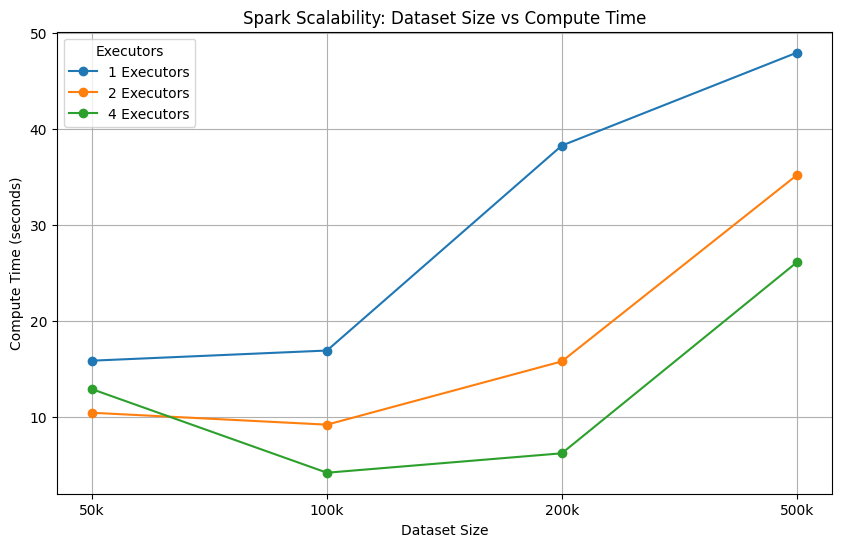

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to DataFrame for plotting
df = pd.DataFrame(results, columns=["Dataset Size", "Executors", "Compute Time"])

# Plotting data size vs computation time (different number of executors)
plt.figure(figsize=(10, 6))
for executors in sorted(df["Executors"].unique()):
    subset = df[df["Executors"] == executors]
    plt.plot(subset["Dataset Size"], subset["Compute Time"], marker='o', label=f"{executors} Executors")

plt.xlabel("Dataset Size")
plt.ylabel("Compute Time (seconds)")
plt.title("Spark Scalability: Dataset Size vs Compute Time")
plt.legend(title="Executors")
plt.grid(True)

# show figure
plt.show()
